<a href="https://colab.research.google.com/github/harald-gen01/generatia_play/blob/main/multi_graph_math_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:
https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-1-build-a-basic-chatbot

In [ ]:
!pip install > /dev/null 2>&1 \
            langchain \
            langchainhub \
            langchain-openai \
            langsmith \
            langchain-community \
            tavily-python \
            youtube_search \
            langgraph

In [ ]:
import os

In [ ]:
from google.colab import userdata


OPENAI_API_KEY = userdata.get('openai_api_key')
TAVILY_API_KEY = userdata.get('tavily_api_key')

LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
LANGCHAIN_TRACING_V2 = userdata.get('LANGCHAIN_TRACING_V2')
LANGCHAIN_PROJECT = userdata.get('LANGCHAIN_PROJECT')

Math equations

In [ ]:
from langchain_core.tools import tool

@tool
def multiply(first_int: int, second_int: int) -> int:
    """Multiply two integers together."""
    return first_int * second_int

@tool
def add(first_int: int, second_int: int) -> int:
    "Add two integers."
    return first_int + second_int

@tool
def exponentiate(base: int, exponent: int) -> int:
    "Exponentiate the base to the exponent power."
    return base**exponent

tools_equations = (multiply, add, exponentiate)

Web and video search

In [ ]:
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools import YouTubeSearchTool

os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY


@tool
def web_search(search: str) -> str:
    """Web search using Tavily API."""
    os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
    search_results = TavilySearchResults(max_results=5)
    return search_results (search)



@tool
def youtube_search(search: str, number: int) -> str:
    """YouTube search."""
    yt_search_tool = YouTubeSearchTool()
    return yt_search_tool(search)

tools_search = (web_search, youtube_search)

Helper to add nodes

In [ ]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

Create nodes

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


Create supervisor

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

roles = ["solver", "searcher"]
system_prompt = (
    "You are a math specialist tasked with managing a conversation between the"
    " following roles:  {roles}. Given the following user request,"
    " respond with the role to act next. Each role will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + roles

# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), roles=", ".join(roles))

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
llm = ChatOpenAI(model="gpt-4o")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

Construct Graph

In [ ]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


solver_agent = create_agent(llm, (tools_equations), "You are math equation solver.")
solver_node = functools.partial(agent_node, agent=solver_agent, name="solver")

search_agent = create_agent(llm, (tools_search), "You are math equation web searcher on internet and youtube.")
search_agent_node = functools.partial(agent_node, agent=search_agent, name="searcher")


workflow = StateGraph(AgentState)
workflow.add_node("solver", solver_node)
workflow.add_node("searcher", search_agent_node)
workflow.add_node("Math_specialist", supervisor_chain)

Connect edges in the graph

In [ ]:
# Add edges for members to report back to the supervisor

for role in roles:
    workflow.add_edge(role, "Math_specialist")

# Conditional map to route based on the "next" field in the state

conditional_map = {k: k for k in roles}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("Math_specialist", lambda x: x["next"], conditional_map)

# Ensure that each node routes to an appropriate next step or ends

workflow.add_edge("solver", "Math_specialist")  # If Equation solver task can finish
workflow.add_edge("searcher", "Math_specialist")  # If Web and video searcher task can finish

# Set the entry point of the workflow

workflow.set_entry_point("Math_specialist")

# Compile the workflow graph
graph = workflow.compile()

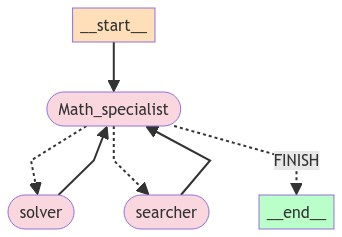

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from langchain_core.messages import BaseMessage

def main():
    while True:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        for event in graph.stream({"messages": [("user", user_input)]}):
            print(event)  # Print the entire event
            print("----")  # Separator
            for value in event.values():
                if "messages" in value and isinstance(value["messages"][-1], BaseMessage):
                    print("Assistant:", value["messages"][-1].content)

if __name__ == "__main__":
    main()